Simulating SVCJ model...


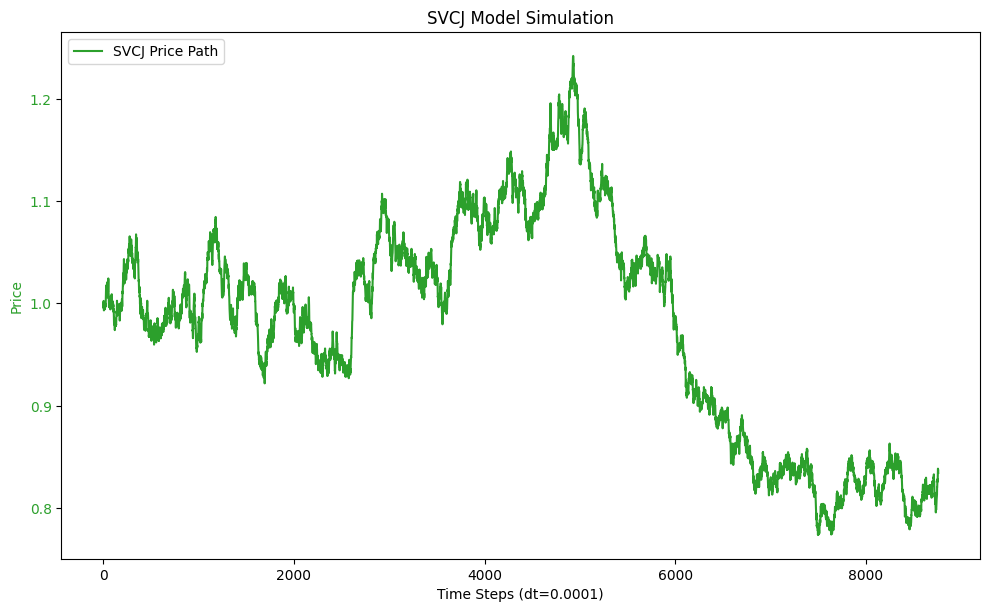

In [19]:
import numpy as np
from svcj.dl.simulator import SVParams, simulate_returns
import matplotlib.pyplot as plt
from typing import Optional

def simulate_single_price_process(
    params: dict, 
    model_type: str, 
    length: int, 
    dt: float, 
    s0: float = 1.0, 
    v0: Optional[float] = None,
    seed: Optional[int] = None
) -> tuple:
    """
    Simulates a single price process for a given model.

    Args:
        params: Dictionary of model parameters.
        model_type: Type of model ('sv', 'svj', or 'svcj').
        length: Number of time steps.
        dt: Time step size.
        s0: Initial price.
        v0: Initial variance. If None, uses v_long from params.
        seed: Random seed for reproducibility.

    Returns:
        A tuple containing:
            - price_path (np.ndarray): Simulated price path.
            - variance_path (np.ndarray): Simulated variance path.
    """
    
    # Convert params dict to SVParams object
    # Ensure all necessary parameters are present based on model_type
    if model_type.lower() == 'sv':
        required_keys = {'mu', 'v_long', 'beta', 'gamma', 'rho'}
        sv_params_dict = {k: params[k] for k in required_keys if k in params}
        # Add default for rho if not provided, though simulator.py might have its own default
        if 'rho' not in sv_params_dict:
            sv_params_dict['rho'] = 0.0 # A common default, adjust as needed
            
    elif model_type.lower() in ['svj', 'svcj']:
        required_keys = {'mu', 'v_long', 'beta', 'gamma', 'mu_j', 'sigma_j', 'lam', 'rho'}
        sv_params_dict = {k: params[k] for k in required_keys if k in params}
        if 'rho' not in sv_params_dict:
            sv_params_dict['rho'] = 0.0

    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    # Create SVParams instance
    # The SVParams class expects specific arguments, so we pass them directly
    try:
        sv_model_params = SVParams(**sv_params_dict)
    except TypeError as e:
        raise ValueError(f"Error creating SVParams. Missing or incorrect parameters for {model_type}. Original error: {e}")


    if v0 is None:
        v0 = sv_model_params.v_long # Use long-term variance as initial variance if not provided

    returns, variance_path = simulate_returns(
        params=sv_model_params,
        steps=length,
        s0=s0,
        v0=v0,
        dt=dt,
        model_type=model_type, # Pass model_type to simulate_returns
        rho=sv_model_params.rho, # Pass rho, simulator might use it
        seed=seed,
        return_variance=True,
        return_jumps=False # Assuming we don't need jump details for a simple price path
    )
    
    # Calculate price path from returns
    price_path = np.empty_like(returns)
    price_path[0] = s0
    price_path[1:] = s0 * np.exp(np.cumsum(returns[1:])) # Compounding returns
    
    return price_path, variance_path

if __name__ == '__main__':
    # Example Usage
    
    # --- SV Model Example ---
    sv_params_example = {
        'mu': 0.05,       # Annualized drift
        'v_long': 0.04,   # Annualized long-term variance (v_long * dt for step variance)
        'beta': 0.98,     # Persistence of variance (closer to 1 means slower decay)
        'gamma': 0.5,     # Volatility of variance
        'rho': -0.7       # Correlation between price and variance shocks
    }
    model_type_example = 'sv'
    length_example = 365*24  # Number of trading days in a year
    dt_example = 1/(365*24)    # Time step (daily)
    s0_example = 1      # Initial stock price
    v0_example = 0.04     # Initial annualized variance
    

    # --- SVCJ Model Example ---
    svcj_params_example = {
        'mu': 0.1,
        'v_long': 0.1,
        'beta': 0.95,
        'gamma': 0.99,
        'mu_j': 0.0,     # Mean of jump size
        'sigma_j': 0.1,    # Volatility of jump size
        'lam': 1,          # Jump intensity (average number of jumps per year)
        'rho': 0
    }
    model_type_svcj_example = 'svcj'
    # Using same length, dt, s0 as SV for comparison, but can be different
    
    print(f"Simulating {model_type_svcj_example.upper()} model...")
    try:
        price_path_svcj, variance_path_svcj = simulate_single_price_process(
            params=svcj_params_example,
            model_type=model_type_svcj_example,
            length=length_example,
            dt=dt_example,
            s0=s0_example,
            v0=None, # Let it use v_long from params
            seed=None
        )

        # Plotting the SVCJ results
        fig, ax1 = plt.subplots(figsize=(10, 6))

        color = 'tab:green'
        ax1.set_xlabel(f'Time Steps (dt={dt_example:.4f})')
        ax1.set_ylabel('Price', color=color)
        ax1.plot(price_path_svcj, color=color, label=f'{model_type_svcj_example.upper()} Price Path')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='upper left')
        


        fig.tight_layout()
        plt.title(f'{model_type_svcj_example.upper()} Model Simulation')
        plt.show()

    except ValueError as e:
        print(f"Error during SVCJ simulation: {e}")
    except Exception as e:
        print(f"An unexpected error occurred during SVCJ simulation: {e}")


In [182]:
import os
import torch
import numpy as np
import pandas as pd
from typing import Dict, Any, Optional, Tuple

# Assuming your project structure allows these imports
# Make sure the 'svcj' package is in your PYTHONPATH
from svcj.dl.models import build_model, ModelConfig
from svcj.dl.simulator import SVParams, simulate_returns, DT_HOUR
from svcj.dl.config import get_param_order, get_param_ranges
from svcj.dl.train import TrainingConfig
from svcj.dl.train import _standardise # Helper for standardizing input


def load_model_generate_path_and_predict(
    checkpoint_path: str,
    true_model_type_for_simulation: str,
    n_runs: int = 1,  # New parameter for number of runs
    path_length_for_simulation: Optional[int] = None,
    device_for_inference: str = "cpu",
    simulation_seed: Optional[int] = None,
    true_params_for_simulation: Optional[Dict[str, float]] = None,
) -> pd.DataFrame:  # Changed return type to DataFrame
    """
    Loads a trained model, generates N random paths for a specified SV-family model,
    and predicts parameters for those paths.

    Args:
        checkpoint_path (str): Path to the model checkpoint (.pt file).
        true_model_type_for_simulation (str): The true model type ('sv', 'svj', 'svcj')
                                              to use for simulating the random path.
        n_runs (int): Number of simulation runs to perform.
        path_length_for_simulation (Optional[int]): Length of the return series to simulate.
                                                    If None, uses seq_len from the loaded model's config.
        device_for_inference (str): Device to run inference on ('cpu' or 'cuda').
        simulation_seed (Optional[int]): Base seed for random path generation.
        true_params_for_simulation (Optional[Dict[str, float]]): Specific true parameters to use
                                                                for simulation. If None, parameters
                                                                will be sampled randomly for each run.

    Returns:
        pd.DataFrame: DataFrame with columns for run_id, parameter names (true_param, pred_param), 
                     and additional metadata like rho if applicable.
    """

    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    # --- 1. Load Checkpoint and Configuration (once) ---
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device_for_inference), weights_only=False)

    if not isinstance(checkpoint, dict) or 'model_state_dict' not in checkpoint or 'config' not in checkpoint:
        raise ValueError("Invalid checkpoint format. Expected a dictionary with "
                         "'model_state_dict' and 'config'.")

    # Load training configuration from checkpoint
    cfg_dict = checkpoint['config']
    print(f"Loaded model config: {cfg_dict}")
    loaded_config = TrainingConfig(
        arch=cfg_dict.get('arch', 'cnn'),
        model_type=cfg_dict.get('model_type', 'svcj'),
        seq_len=cfg_dict.get('seq_len', 672),
        n_samples=cfg_dict.get('n_samples', 10000), # Dummy, not used for inference
        val_split=cfg_dict.get('val_split', 0.1), # Dummy
        dt=cfg_dict.get('dt', DT_HOUR),
        rho=cfg_dict.get('rho', None),
        epochs=cfg_dict.get('epochs', 100), # Dummy
        batch_size=cfg_dict.get('batch_size', 512), # Dummy
        lr=cfg_dict.get('lr', 1e-3), # Dummy
        weight_decay=cfg_dict.get('weight_decay', 1e-4), # Dummy
        mu_mode=cfg_dict.get('mu_mode', 'raw'),
        mixed_precision=cfg_dict.get('mixed_precision', True), # Dummy
        early_stop_patience=cfg_dict.get('early_stop_patience', 10), # Dummy
        clip_predictions=cfg_dict.get('clip_predictions', True),
        normalize_returns=cfg_dict.get('normalize_returns', False),
        standardize_params=cfg_dict.get('standardize_params', False),
        seed=cfg_dict.get('seed', 42), # Dummy
        logdir=cfg_dict.get('logdir', 'runs/default'), # Dummy
        load_checkpoint=cfg_dict.get('load_checkpoint', False) # Dummy
    )
    
    trained_model_arch = loaded_config.arch
    trained_model_type = loaded_config.model_type
    seq_len_for_model = loaded_config.seq_len
    mu_mode_for_model = loaded_config.mu_mode
    dt_for_model_config = loaded_config.dt

    # Load normalization statistics
    if 'normalization' not in checkpoint:
        raise ValueError("Checkpoint must contain 'normalization' statistics (x_mean, x_std, y_mean, y_std).")
    norm_stats = checkpoint['normalization']
    x_mean = norm_stats['x_mean'].to(device_for_inference)
    x_std = norm_stats['x_std'].to(device_for_inference)
    y_mean = norm_stats['y_mean'].to(device_for_inference)
    y_std = norm_stats['y_std'].to(device_for_inference)
    
    # Get parameter order for the trained model
    trained_model_param_order = get_param_order(trained_model_type)
    if mu_mode_for_model == "analytical":
        if len(y_mean) == len(trained_model_param_order) -1:
             trained_model_param_order_for_preds = trained_model_param_order[1:]
        else:
            trained_model_param_order_for_preds = trained_model_param_order
    else:
        trained_model_param_order_for_preds = trained_model_param_order

    # --- Load Model (once) ---
    original_n_params_trained_model = len(get_param_order(trained_model_type))
    
    print(f"Building model with architecture: {trained_model_arch}")
    model = build_model(
        kind=trained_model_arch,
        model_type=trained_model_type,
        n_params=original_n_params_trained_model,
        seq_len=seq_len_for_model
    ).to(device_for_inference)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"Model loaded successfully: {type(model).__name__}")

    # --- Setup for multiple runs ---
    if path_length_for_simulation is None:
        path_length_for_simulation = seq_len_for_model

    # Initialize RNG with base seed
    base_rng = np.random.default_rng(simulation_seed)
    
    true_param_order_for_simulation = get_param_order(true_model_type_for_simulation)
    
    # Get parameter ranges for sampling (if needed)
    if true_params_for_simulation is None:
        param_ranges_for_simulation = get_param_ranges(true_model_type_for_simulation, dt=dt_for_model_config, use_ficura=True)

    # Storage for results
    results = []

    # --- Run N simulations ---
    for run_id in range(n_runs):
        print(f"Running simulation {run_id + 1}/{n_runs}")
        
        # Create a unique seed for this run
        run_seed = base_rng.integers(0, 2**31) if simulation_seed is not None else None
        run_rng = np.random.default_rng(run_seed)
        
        # --- 2. Generate Random Path for this run ---
        if true_params_for_simulation is None:
            # Sample random parameters for this run
            sampled_true_params_list = []
            for param_name in true_param_order_for_simulation:
                if param_name in param_ranges_for_simulation:
                    sampled_true_params_list.append(run_rng.uniform(
                        param_ranges_for_simulation[param_name].low, 
                        param_ranges_for_simulation[param_name].high
                    ))
                else:
                    raise ValueError(f"Parameter {param_name} not found in ranges for {true_model_type_for_simulation}")
            
            true_params_values_for_sim = np.array(sampled_true_params_list)
        else:
            # Use provided true parameters for all runs
            true_params_values_for_sim = np.array([true_params_for_simulation[p_name] for p_name in true_param_order_for_simulation])

        # Create SVParams object for simulation
        simulation_rho = loaded_config.rho if loaded_config.rho is not None else run_rng.uniform(-0.9, 0.9)
        if true_model_type_for_simulation == "sv":
            sv_params_for_simulation = SVParams.from_sequence(
                true_params_values_for_sim, 
                true_model_type_for_simulation, 
                rho=0.0,
                dt=dt_for_model_config
            )
        else:
            sv_params_for_simulation = SVParams.from_sequence(
                true_params_values_for_sim, 
                true_model_type_for_simulation, 
                rho=simulation_rho, 
                dt=dt_for_model_config
            )

        return_series_np = simulate_returns(
            params=sv_params_for_simulation,
            steps=path_length_for_simulation,
            dt=dt_for_model_config,
            model_type=true_model_type_for_simulation,
            rho=simulation_rho,
            seed=run_seed,
            return_variance=False
        )
        return_series_np = return_series_np.astype(np.float32)

        # --- 3. Prepare Input for Model ---
        if len(return_series_np) > seq_len_for_model:
            input_series_np = return_series_np[-seq_len_for_model:]
        elif len(return_series_np) < seq_len_for_model:
            padding = np.zeros(seq_len_for_model - len(return_series_np), dtype=np.float32)
            input_series_np = np.concatenate((padding, return_series_np))
        else:
            input_series_np = return_series_np

        input_tensor = torch.from_numpy(input_series_np).to(device_for_inference)
        normalized_input_tensor = _standardise(input_tensor, x_mean, x_std)
        normalized_input_tensor = normalized_input_tensor.unsqueeze(0).unsqueeze(0)

        # --- 4. Predict ---
        with torch.no_grad():
            predicted_params_norm = model(normalized_input_tensor, mu_mode_for_model)
            
        # --- 5. Denormalize Predictions ---
        if predicted_params_norm.shape[1] != y_mean.shape[0]:
             raise ValueError(f"Prediction dimension ({predicted_params_norm.shape[1]}) does not match "
                             f"y_mean dimension ({y_mean.shape[0]}) from checkpoint.")

        predicted_params_denorm = predicted_params_norm * y_std + y_mean
        predicted_params_denorm_np = predicted_params_denorm.cpu().numpy().squeeze()

        predicted_params_dict = dict(zip(trained_model_param_order_for_preds, predicted_params_denorm_np))

        # Handle analytical mu mode
        if mu_mode_for_model == "analytical":
            empirical_mu = np.mean(input_series_np) / dt_for_model_config
            predicted_params_dict_full = {trained_model_param_order[0]: empirical_mu}
            predicted_params_dict_full.update(predicted_params_dict)
            predicted_params_dict = predicted_params_dict_full

        # --- 6. Store results for this run ---
        true_params_dict = dict(zip(true_param_order_for_simulation, true_params_values_for_sim))
        if true_model_type_for_simulation != "sv":
            true_params_dict['rho'] = simulation_rho

        # Create row for DataFrame
        row = {'run_id': run_id}
        
        # Add true parameters
        for param_name, param_value in true_params_dict.items():
            row[f'true_{param_name}'] = param_value
            
        # Add predicted parameters
        for param_name, param_value in predicted_params_dict.items():
            row[f'pred_{param_name}'] = param_value
            
        # Add metadata
        row['simulation_seed'] = run_seed
        row['path_length'] = path_length_for_simulation
        
        results.append(row)

    # --- 7. Create and return DataFrame ---
    df = pd.DataFrame(results)
    print(f"Completed {n_runs} simulation runs")
    return df


# Example 3: Provide specific true parameters for SVCJ simulation
print("\n--- Example 3: Simulate SVCJ with specified true params, Predict SVCJ ---")
# These params should ideally be at the scale of dt used for training the loaded model
# For this example, we'll just use some plausible numbers.
# If your model was trained with dt=DT_HOUR, these values should reflect hourly scale.
# If loaded_config.dt gives daily, then these should be daily scale.
# Using get_param_ranges with the loaded config's dt is a good way to see typical scales.

checkpoint_file_to_use = '/home/pduce/sbt/svcj/runs/sv_family/svj_transformer_huge_run/ckpt/best.pt'
 
loaded_chpt_for_dt_ref = torch.load(checkpoint_file_to_use, map_location='cpu')
ref_dt = loaded_chpt_for_dt_ref['config'].get('dt', DT_HOUR)
svcj_ranges_at_ref_dt = get_param_ranges("svcj", dt=ref_dt, range_source='default')

rng = np.random.default_rng(123)

specified_true_svcj_params = {
    'mu': 0.5,
    'v_long': 0.1,
    'beta': 0.95,
    'gamma': 0.99,
    'mu_j': 0.0,
    'sigma_j': 0.1,
    'lambda': 2,
    'rho': 1
}
# Rho will be sampled if not in the dict and model is svj/svcj

df = load_model_generate_path_and_predict(
    checkpoint_path=checkpoint_file_to_use,
    true_model_type_for_simulation="svcj",
    true_params_for_simulation=specified_true_svcj_params,
    device_for_inference="cpu",
    n_runs=10
)



--- Example 3: Simulate SVCJ with specified true params, Predict SVCJ ---
Loaded model config: {'arch': 'transformer', 'model_type': 'svj', 'seq_len': 2520, 'n_samples': 500000, 'val_split': 0.1, 'dt': 0.00011415525114155251, 'rho': None, 'param_range_source': 'default', 'epochs': 100, 'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'mu_mode': 'raw', 'mixed_precision': True, 'early_stop_patience': 6, 'validate_every': 1, 'clip_predictions': True, 'normalize_returns': False, 'standardize_params': False, 'return_variance': False, 'return_jumps': False, 'use_cached_dataset': False, 'cache_path': None, 'device': 'cuda', 'num_workers': 4, 'seed': 42, 'run_name': 'svj_transformer_huge_run', 'load_checkpoint': False, 'spawn_tensorboard': True, 'tensorboard_port': 6006, 'open_browser': True, 'logdir': 'runs/sv_family/svj_transformer_huge_run'}
Building model with architecture: transformer
Model loaded successfully: TransformerRegressor
Running simulation 1/10


/tmp/ipykernel_373346/4230524110.py:265: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_chpt_for_dt_ref = torch.load(checkpoint_file_to_use, map_location='cpu')
/home/

Running simulation 2/10
Running simulation 3/10
Running simulation 4/10
Running simulation 5/10
Running simulation 6/10
Running simulation 7/10
Running simulation 8/10
Running simulation 9/10
Running simulation 10/10
Completed 10 simulation runs


In [184]:
df

,run_id,true_mu,true_v_long,true_beta,true_gamma,true_mu_j,true_sigma_j,true_lambda,true_rho,pred_mu,pred_v_long,pred_beta,pred_gamma,pred_mu_j,pred_sigma_j,pred_lambda,simulation_seed,path_length
0,0,0.5,0.1,0.95,0.99,0.0,0.1,2.0,0.586368,-0.249779,0.000110,0.499504,0.369430,0.034234,0.065283,43.391647,None,2520
1,1,0.5,0.1,0.95,0.99,0.0,0.1,2.0,0.630172,-0.183777,0.000109,0.502958,0.368761,0.036194,0.066129,43.327934,None,2520
2,2,0.5,0.1,0.95,0.99,0.0,0.1,2.0,0.249652,-0.161072,0.000109,0.519032,0.313194,0.041067,0.067181,43.377319,None,2520
3,3,0.5,0.1,0.95,0.99,0.0,0.1,2.0,0.335138,-0.167423,0.000109,0.519353,0.295393,0.042977,0.065726,43.342793,None,2520
4,4,0.5,0.1,0.95,0.99,0.0,0.1,2.0,-0.082809,-0.136762,0.000109,0.518945,0.303251,0.043622,0.066159,43.351624,None,2520
5,5,0.5,0.1,0.95,0.99,0.0,0.1,2.0,0.049758,-0.153135,0.000109,0.523523,0.276811,0.039383,0.065134,43.336845,None,2520
6,6,0.5,0.1,0.95,0.99,0.0,0.1,2.0,0.287444,-0.191676,0.000110,0.488095,0.440035,0.042030,0.065938,43.383926,None,2520
7,7,0.5,0.1,0.95,0.99,0.0,0.1,2.0,0.739568,-0.044402,0.000109,0.526092,0.283666,0.045353,0.068077,43.283829,None,2520
8,8,0.5,0.1,0.95,0.99,0.0,0.1,2.0,-0.669721,-0.115981,0.000109,0.519307,0.307703,0.044021,0.065763,43.349876,None,2520
9,9,0.5,0.1,0.95,0.99,0.0,0.1,2.0,-0.228421,-0.129221,0.000109,0.533991,0.240718,0.039688,0.064356,43.354889,None,2520
